# Slidin' Videos: Use high-precision text tracking and semantic segmentation for chapters generation

#### Please register for the Slidin' Videos challenge to get download URLs used in this notebook 

## 1. Deeplab finetuning
#### DeepLabV3 model is a pretrained model for semantic segmentation of images. We will finetune it on Slidin' Videos dataset of slide titles

In [2]:
!git clone https://github.com/msminhas93/DeepLabv3FineTuning.git
#!pip install torch==1.6 torchvision==0.7 pandas scikit-learn==1.2.2
!pip install opencv-python-headless==4.5.4.60 Shapely==1.8.5.post1 Pillow==9.0.1 easyocr==1.6.2

Cloning into 'DeepLabv3FineTuning'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 352 (delta 3), reused 9 (delta 3), pack-reused 340
Receiving objects: 100% (352/352), 4.09 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (24/24), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.


#### Download title masks collection and unzip it to the cloned repository. 

In [ ]:
!unzip -q /kaggle/input/ITU-Project/Train -d DeepLabv3FineTuning/

#### Training DeepLab model: our goal is to maximize test_f1_score
#### You may want to play with number of epochs, learning rate and loss function to get better results

In [3]:
!pip install --upgrade pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.


In [4]:
import torch

In [5]:
# Set the random seed
torch.manual_seed(42)

In [19]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

0

In [19]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

In [9]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head

    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.

    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [10]:
%cd /kaggle/working/DeepLabv3FineTuning
from pathlib import Path

#from segmentation_models_pytorch.losses.jaccard  import JaccardLoss
#from segmentation_models_pytorch.losses.constants import BINARY_MODE
#criterion = JaccardLoss(mode=BINARY_MODE)

import torch
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils import data

import datahandler
#from model import createDeepLabv3
from trainer import train_model

# Create the deeplabv3 resnet101 model which is pretrained on a subset
# of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
model = createDeepLabv3()
model.train()

# directory to the train folder data
data_directory = Path("/kaggle/input/ITU-Project/Train")
# Create the experiment directory if not present
exp_directory = Path("DemoExp")
if not exp_directory.exists():
    exp_directory.mkdir()

/kaggle/working/DeepLabv3FineTuning


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
epochs = 8

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

# Create the dataloader
dataloaders = datahandler.get_dataloader_single_folder(
    data_directory, fraction=0.1, image_folder="Images", 
    mask_folder="Masks", batch_size=4)



# Specify the loss function
criterion = torch.nn.MSELoss(reduction='sum')

# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
_ = train_model(model, 
                criterion,
                dataloaders,
                optimizer,
                bpath=exp_directory,
                metrics=metrics,
                num_epochs=epochs)

# Save the trained model
torch.save(model, exp_directory / 'weights.pt')

# Terminate
exit()
%cd ../

Epoch 1/8
----------


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:20<00:00,  1.54s/it]

Train Loss: 6323.1045



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.06it/s]

Test Loss: 1786.6948
{'epoch': 1, 'Train_loss': 6323.1044921875, 'Test_loss': 1786.69482421875, 'Train_f1_score': 0.7201100893949656, 'Train_auroc': 0.981103649052091, 'Test_f1_score': 0.5613784521852809, 'Test_auroc': 0.9648725479401903}
Epoch 2/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:22<00:00,  1.54s/it]

Train Loss: 16853.5469



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:50<00:00,  1.07it/s]

Test Loss: 3956.1345
{'epoch': 2, 'Train_loss': 16853.546875, 'Test_loss': 3956.134521484375, 'Train_f1_score': 0.749934380203785, 'Train_auroc': 0.9876538103784467, 'Test_f1_score': 0.629584207241347, 'Test_auroc': 0.9731398350533692}
Epoch 3/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:20<00:00,  1.54s/it]

Train Loss: 1651.5385



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.06it/s]

Test Loss: 1059.1981
{'epoch': 3, 'Train_loss': 1651.5384521484375, 'Test_loss': 1059.1981201171875, 'Train_f1_score': 0.7723024115300275, 'Train_auroc': 0.9898146165975139, 'Test_f1_score': 0.7742942735003803, 'Test_auroc': 0.9751746252698523}
Epoch 4/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:22<00:00,  1.54s/it]

Train Loss: 3031.6895



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.06it/s]

Test Loss: 3064.2651
{'epoch': 4, 'Train_loss': 3031.689453125, 'Test_loss': 3064.26513671875, 'Train_f1_score': 0.7872907967531243, 'Train_auroc': 0.9909938808816087, 'Test_f1_score': 0.6715634944278663, 'Test_auroc': 0.9680524666947964}
Epoch 5/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:23<00:00,  1.54s/it]

Train Loss: 2788.3462



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:50<00:00,  1.06it/s]

Test Loss: 1196.2310
{'epoch': 5, 'Train_loss': 2788.34619140625, 'Test_loss': 1196.23095703125, 'Train_f1_score': 0.8013375576267174, 'Train_auroc': 0.9917573247319607, 'Test_f1_score': 0.7663393169469814, 'Test_auroc': 0.9788965133640921}
Epoch 6/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:20<00:00,  1.54s/it]

Train Loss: 3702.0942



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.06it/s]

Test Loss: 478.3633
{'epoch': 6, 'Train_loss': 3702.09423828125, 'Test_loss': 478.36334228515625, 'Train_f1_score': 0.8249250774063926, 'Train_auroc': 0.9935880572865982, 'Test_f1_score': 0.7364258454840773, 'Test_auroc': 0.9620305173110244}
Epoch 7/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:20<00:00,  1.54s/it]

Train Loss: 5249.0581



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.05it/s]

Test Loss: 1091.8910
{'epoch': 7, 'Train_loss': 5249.05810546875, 'Test_loss': 1091.8909912109375, 'Train_f1_score': 0.8255118839634116, 'Train_auroc': 0.9927843373657761, 'Test_f1_score': 0.7418164711955854, 'Test_auroc': 0.977361959182661}
Epoch 8/8
----------



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 481/481 [12:19<00:00,  1.54s/it]

Train Loss: 6710.3887



/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 54/54 [00:51<00:00,  1.06it/s]


Test Loss: 2772.3386
{'epoch': 8, 'Train_loss': 6710.388671875, 'Test_loss': 2772.338623046875, 'Train_f1_score': 0.8251894633663315, 'Train_auroc': 0.9928317033829989, 'Test_f1_score': 0.7942633650257401, 'Test_auroc': 0.9767864512110304}
Training complete in 105m 44s
Lowest Loss: 478.363342
/kaggle/working


## 2. Making the submission
#### Unpack the testset

In [1]:
# !unzip -q Test.zip

unzip:  cannot find or open Test.zip, Test.zip.zip or Test.zip.ZIP.


#### Load finetuned deeplab model and define helper functions

In [1]:
import glob
import os
import json
import cv2    
import torch
import numpy as np
import pandas as pd

from torchvision import transforms  
from PIL import Image

deeplab_width = 768
deeplab_height = 432
deeplab = torch.load('/kaggle/working/DeepLabv3FineTuning/DemoExp/weights.pt')
deeplab.eval()
     

def boxify(out, boxes):
    return [ torch.mean(out[b[0]:b[1], b[2]:b[3]]).item()  for b in boxes ]      

def titlesegment(image, boxes):
    # Resize the frame to the training input size
    inputs = transforms.ToTensor()(Image.fromarray(image, mode="RGB"))
    inputs = inputs.reshape(1, *inputs.shape).to('cuda')
    
    with torch.set_grad_enabled(False):
        outputs = deeplab(inputs)
        out = outputs['out'][0][0]
        box_scores = boxify(out, boxes)
        return out, np.array(box_scores)
    
def occupation(boxes):
    area = lambda b: (b[1]-b[0]) * (b[3]-b[2])
    y1, y2 = min([b[0] for b in boxes ]), max([b[1] for b in boxes ])
    x1, x2 = min([b[2] for b in boxes ]), max([b[3] for b in boxes ])
    return 1.0 * sum([ area(b) for b in boxes ]) / area([y1, y2, x1, x2])

# Locates a paragraph of text with the highest probability 
# to be a slide title 
def pickonetitle(boxes, scores):
    if len(boxes) == 0:
        return []
        
    best_idx = np.argmax(scores)
    best = boxes[best_idx]

    candidates = { i for i, box in enumerate(boxes) 
        if abs(box['fontsize']-best['fontsize']) <= best['fontsize'] * 0.25 
            and scores[best_idx] - scores[i] < 0.6 }
    
    while occupation([ boxes[i]['bbox'] for i in candidates ]) < 0.75:
        combinations = [ candidates - {j} for j in candidates if j != best_idx ]
        candidates = max(combinations, 
            key=lambda comb: occupation([ boxes[j]['bbox'] for j in comb ]))
            
    title_boxes = [ boxes[i] for i in candidates ]
    return title_boxes    

#### Now, we're going to use EasyOCR package to "read" the titles. Modern OCR solutions may still produce a handful of errors, which is why you're encouraged to apply a language model or alternative OCR model to fix possible misspelings. 

In [2]:
from shapely.geometry import Polygon, LineString

import easyocr
reader = easyocr.Reader(['en']) 

def sameline(a, b):
    return ((min(a['bbox'][1], b['bbox'][1]) - max(a['bbox'][0], b['bbox'][0]))
            / min(a['height'], b['height'])) >= 0.8
            
def isbelow(a, b):
    return not sameline(a, b) and a['bbox'][0] > b['bbox'][0]  
    
def isright(a, b):
    return sameline(a, b) and a['bbox'][2] > b['bbox'][2]  

def sort_boxes(boxes):              
    boxes_ = []
    for b in boxes:
        i = 0
        while i < len(boxes_) and (isbelow(b, boxes_[i]) or isright(b, boxes_[i])):
            i += 1
        boxes_.insert(i, b)
    return boxes_

def _norm_bbox(bbox):
    return  [ int(max(0, min([ p[1] for p in bbox ]))), 
              int(max([ p[1] for p in bbox ])), 
              int(max(0, min([ p[0] for p in bbox ]))), 
              int(max([ p[0] for p in bbox ])) ]

def process_ocr(ocr_results):
    items = []
    for bbox, text, conf in ocr_results:
        if text == '' or conf <= 0:
            continue  
        if not isinstance(bbox, list):
            bbox = bbox.tolist()
        item = {}
        item['width'] = LineString(bbox[0:2]).length
        item['height'] = LineString(bbox[1:3]).length
        item['area'] = item['width'] * item['height']
        item['fontsize'] = 1.0 * item['width'] / len(text)
        item['bbox'] = _norm_bbox(bbox)            
        item['text'] = text
        item['conf'] = float(conf)
        items.append(item)
    return items     

def read_text(img):
    return process_ocr(reader.readtext(img))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data exploration
#### First, we will pick some random test slide and will extract any instance of text on it

In [3]:
from PIL import Image
import numpy as np

# Load the image using PIL
pil_image = Image.open('/kaggle/input/ITU-Project/Test/Images/Id_06cra35n6n.jpg')

# Convert the PIL Image to numpy array
img_array = np.array(pil_image)

# Pass the numpy array to the read_text function
textboxes_ = read_text(img_array)


'Test slide #33'

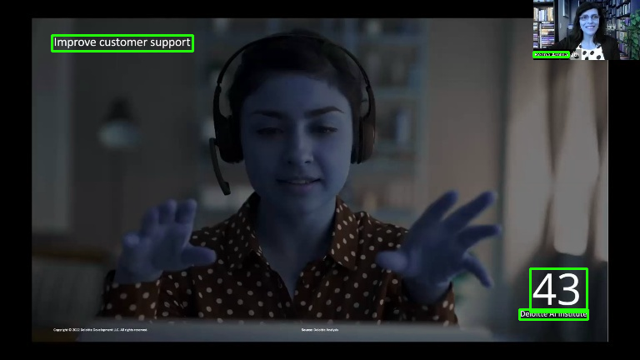

,width,height,area,fontsize,bbox,text
0,169.0,19.0,3211.0,7.041667,"[42, 61, 62, 231]",Improve customer support
1,42.0,6.0,252.0,6.000000,"[62, 68, 640, 682]",Bcnaein
2,68.0,52.0,3536.0,34.000000,"[322, 374, 636, 704]",43
3,82.0,12.0,984.0,3.904762,"[371, 383, 623, 705]",Deloitte Al Institute


In [4]:
from IPython.display import display, JSON, Image as IImage


from shapely.geometry import Polygon, LineString

import easyocr
reader = easyocr.Reader(['en']) 

def sameline(a, b):
    return ((min(a['bbox'][1], b['bbox'][1]) - max(a['bbox'][0], b['bbox'][0]))
            / min(a['height'], b['height'])) >= 0.8
            
def isbelow(a, b):
    return not sameline(a, b) and a['bbox'][0] > b['bbox'][0]  
    
def isright(a, b):
    return sameline(a, b) and a['bbox'][2] > b['bbox'][2]  

def sort_boxes(boxes):              
    boxes_ = []
    for b in boxes:
        i = 0
        while i < len(boxes_) and (isbelow(b, boxes_[i]) or isright(b, boxes_[i])):
            i += 1
        boxes_.insert(i, b)
    return boxes_

def _norm_bbox(bbox):
    return  [ int(max(0, min([ p[1] for p in bbox ]))), 
              int(max([ p[1] for p in bbox ])), 
              int(max(0, min([ p[0] for p in bbox ]))), 
              int(max([ p[0] for p in bbox ])) ]

def process_ocr(ocr_results):
    items = []
    for bbox, text, conf in ocr_results:
        if text == '' or conf <= 0:
            continue  
        if not isinstance(bbox, list):
            bbox = bbox.tolist()
        item = {}
        item['width'] = LineString(bbox[0:2]).length
        item['height'] = LineString(bbox[1:3]).length
        item['area'] = item['width'] * item['height']
        item['fontsize'] = 1.0 * item['width'] / len(text)
        item['bbox'] = _norm_bbox(bbox)            
        item['text'] = text
        item['conf'] = float(conf)
        items.append(item)
    return items     

def read_text(img):
    return process_ocr(reader.readtext(img))

def draw_boxes(frame, boxes):
    for box in boxes:
        frame = cv2.rectangle(frame, (box[2], box[0]), (box[3], box[1]), (36,255,12), 2)
    return frame

# Load some test image and read the text on it
slide_ = cv2.imread('/kaggle/input/ITU-Project/Test/Images/Id_0nuof9yv6n.jpg')

textboxes_ = read_text(slide_)

textdata_ = pd.DataFrame(list(textboxes_))
del textdata_['conf']
             
slide_debug_ = draw_boxes(slide_, [ box['bbox'] for box in textboxes_ ])

display(f"Test slide #33", 
    Image.fromarray(slide_debug_).resize((640,360)), textdata_.head(5))

#### Now, we will apply finetuned DeepLab model and "score" each textbox as to whether it might be a title or not

'Test slide #33 (segmentation output)'

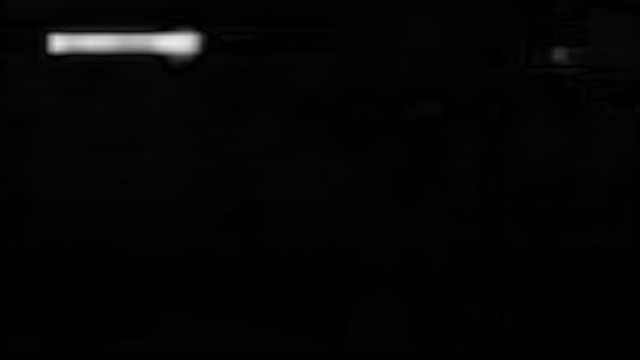

,width,height,area,fontsize,bbox,text,score
0,169.0,19.0,3211.0,7.041667,"[42, 61, 62, 231]",Improve customer support,0.725236
1,42.0,6.0,252.0,6.000000,"[62, 68, 640, 682]",Bcnaein,0.092609
2,68.0,52.0,3536.0,34.000000,"[322, 374, 636, 704]",43,0.001865
3,82.0,12.0,984.0,3.904762,"[371, 383, 623, 705]",Deloitte Al Institute,0.002395


In [5]:
out, scores = titlesegment(slide_, [ box['bbox'] for box in textboxes_ ])
out_mask = (np.abs(out.cpu().numpy())*255).astype(np.uint8)

textdata_['score'] = scores

display(f"Test slide #33 (segmentation output)", Image.fromarray(out_mask).resize((640,360)), textdata_.head(5))

#### Iterate this method on all test images

In [6]:
# directory of the test images data
images = sorted(glob.glob('/kaggle/input/ITU-Project/Test/Images/*.jpg'))
result = []

for path in images:
    image = cv2.imread(path)
    textboxes = read_text(image)

    out, scores = titlesegment(image, [ box['bbox'] for box in textboxes ])
    titleboxes = pickonetitle(textboxes, scores)
    
    # Sort text boxes as you would read it in English: from top to bottom
    # and from left to right
    titleboxes = sort_boxes(titleboxes)
    title = ' '.join(box['text'] for box in titleboxes)    
    
    image_id = path.split('/')[-1]
    result.append([image_id, title])


#### Convert the result to a dataframe and save it

In [7]:
df = pd.DataFrame.from_records(result, columns=['ID','Title'])
df

,ID,Title
0,Id_06cra35n6n.jpg,Detect potential security threats
1,Id_08bjq60t4q.jpg,Our team
2,Id_0g2lwbt3sa.jpg,Part 2: Convection DL instabilities & spurious...
3,Id_0h1arzmj2p.jpg,"Take any ""standard"" black box CNN:"
4,Id_0khgx7z8tk.jpg,Predict; prevent and detect insurance fraud
...,...,...
285,Id_zp77iny60p.jpg,Monitor environmental changes and measure ener...
286,Id_zrs2rtf33n.jpg,The Safe System Pillars
287,Id_zvhdc5e9ra.jpg,Stop explaining black box machine learning mod...
288,Id_zvhpkbv4rk.jpg,Interactive Machines


In [8]:
df.to_csv('/kaggle/working/Newsub_title_extr3.csv', index=False)